In [1]:
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel

from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets import human36m_EXTENDED
import copy
from mvn.utils.img import get_square_bbox, resize_image, crop_image, normalize_image, scale_bbox
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline
import math

In [2]:
import os
import shutil
import argparse
import time
import json
from datetime import datetime
from collections import defaultdict
from itertools import islice
import pickle
import copy

import numpy as np
import cv2

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel

from mvn.models.triangulation_512x512 import VolumetricTriangulationNet_Wholebody_512x512
from mvn.models.loss import KeypointsMSELoss, KeypointsMSESmoothLoss, KeypointsMAELoss, KeypointsL2Loss, VolumetricCELoss

from mvn.utils import img, multiview, op, vis, misc, cfg
from mvn.datasets import human36m_custom
from mvn.datasets import utils as dataset_utils
#from mvn.datasets import NC_INTERNAL_MULTIVIEW

import pickle
import matplotlib.pyplot as plt
import cv2
from matplotlib.pyplot import figure
import numpy
import copy

%matplotlib inline

/opt/conda/lib/python3.7/site-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '


In [3]:
from mmpose.apis import init_pose_model

def get_pose_net(device='cuda:0'):
    backbone_config="/workspace/learnable_triangulation/mmpose/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py"
#     backbone_checkpoint='https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_384x288_dark-741844ba_20200812.pth'
    backbone_checkpoint='https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth'
    pose_model = init_pose_model(backbone_config, backbone_checkpoint)#, device=args.device.lower()
    pose_model.train()

    return pose_model

def parse_args(argstring):
    parser = argparse.ArgumentParser()

    parser.add_argument("--config", type=str, required=True, help="Path, where config file is stored")
    parser.add_argument('--eval', action='store_true', help="If set, then only evaluation will be done")
    parser.add_argument('--eval_dataset', type=str, default='val', help="Dataset split on which evaluate. Can be 'train' and 'val'")

    parser.add_argument("--local_rank", type=int, help="Local rank of the process on the node")
    parser.add_argument("--seed", type=int, default=42, help="Random seed for reproducibility")

    parser.add_argument("--logdir", type=str, default="/Vol1/dbstore/datasets/k.iskakov/logs/multi-view-net-repr", help="Path, where logs will be stored")

    args = parser.parse_args(argstring)
    return args

def make_output(batch_sample, idx_cam, keypoints_3D):
    batch_image_cam = batch_sample['images'][0, :, :, :, :][idx_cam,:,:,:]
    batch_image_cam = cv2.normalize(batch_image_cam, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    batch_cameras = batch['cameras']
    batch_camera = batch_cameras[idx_cam][0]
    
    P = batch_camera.projection
    #D2_keypoints = keypoints_2d.detach().cpu().numpy().astype(np.float64)[0] # (view, joint, xy)
    D3_keypoints = keypoints_3D.detach().cpu().numpy().astype(np.float64)[0]
    num_joint = keypoints_3D.shape[1]
    D3_keypoints = cv2.hconcat([D3_keypoints, np.ones((num_joint,1))]) # for # [17,4] homogenious
    
    for joint in range(num_joint):
        one_point = D3_keypoints[joint,:4]

        projected = np.matmul(P, one_point)
        projected = projected/projected[-1]
        batch_image_cam = cv2.circle(batch_image_cam, (int(projected[0]),int(projected[1])), 0, [0, 0, 255], 10)
        #batch_image_cam = cv2.circle(batch_image_cam, (int(D2_keypoints[idx_cam,joint,0]),int(D2_keypoints[idx_cam,joint,1])), 0, [255, 0, 0], 10)

    return batch_image_cam

def gaussian_2d(mesh_x, mesh_y, target_x, target_y, sig):
    retval = torch.exp(-((mesh_x - target_x)**2 + (mesh_y - target_y)**2)/(2*sig**2))
    return retval

In [4]:
args = parse_args(['--eval', '--eval_dataset', 'train', '--config',\
                   'experiments/human36m/train/human36m_vol_softmax_LT_WHOLEBODY_SMPL_dataset.yaml',\
                  '--logdir', './logs'])

print("Number of available GPUs: {}".format(torch.cuda.device_count()))

is_distributed = False
master = True
device = torch.device(0)

# config
#config = cfg.load_config(args.config)
config = cfg.load_config(args.config)

print('yk made train shuffle false for visualization')
print('yk made batch size 1 for memory..')
config.dataset.train.shuffle = False
config.opt.batch_size = 1
config.model.use_gt_pelvis = True

config.opt.n_iters_per_epoch = config.opt.n_objects_per_epoch // config.opt.batch_size


Number of available GPUs: 1
yk made train shuffle false for visualization
yk made batch size 1 for memory..


In [5]:
class hrnet_backbone_test(torch.nn.Module):
    def __init__(self, reference_hrnet, device='cuda:0'):
        super().__init__()
        self.tmp_hrnet = reference_hrnet
#         self.tmp_hrnet.eval()
        self.hrnet_backbone = self.tmp_hrnet.backbone.to(device)
        # self.hrnet_keypoint_head = self.tmp_hrnet.keypoint_head
        # original hrnet_keypoint_head : torch.nn.Conv2d(48, 133, kernel_size=(1, 1), stride=(1, 1))
        self.hrnet_keypoint_head = torch.nn.Conv2d(48, 25, kernel_size=(1, 1), stride=(1, 1)).to(device)
        torch.nn.init.xavier_uniform(self.hrnet_keypoint_head.weight)
#         torch.nn.init.xavier_uniform(self.hrnet_keypoint_head.bias)
        print('hrnet_keypoint_head weights are initialized! : xavier')
    
        del self.tmp_hrnet
            
    def forward(self, x):
        x = self.hrnet_backbone(x)[0] # I don't know why.
        x = self.hrnet_keypoint_head(x)
        
        return x


In [6]:
tmp_hrnet = get_pose_net()
tmp_hrnet.eval()
joint25_hrnet_test_backbone = hrnet_backbone_test(tmp_hrnet)

#### MODEL
model = joint25_hrnet_test_backbone

load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth
hrnet_keypoint_head weights are initialized! : xavier


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # Remove the CWD from sys.path while we load stuff.


In [7]:
model.eval()

hrnet_backbone_test(
  (hrnet_backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [8]:
# option_384x288= ?
# image_shape=(384, 384)

shuffle_data = False

# h36m_root = '/datasets/human3.6m_LT/processed/'

# HUMAN36M_dataset = human36m_EXTENDED.Human36MMultiViewDataset_EXTENDED(h36m_root='/datasets/human36m/images',
#                  labels_path="/datasets/human36m/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy",
#                  pred_results_path=None,
#                  image_shape=(512, 512),
#                  train=True,
#                  test=False,
#                  retain_every_n_frames_in_test=1,
#                  with_damaged_actions=False,
#                  cuboid_side=2000.0,
#                  scale_bbox=1.2,
#                  norm_image=True,
#                  kind="mpii",
#                  undistort_images=False,
#                  ignore_cameras=[],
#                  crop=True,
#                  option_384x288=False)

HUMAN36M_dataset = human36m_EXTENDED.Human36MMultiViewDataset_EXTENDED(h36m_root='/datasets/human36m/images',
                 labels_path="/datasets/human36m/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy",
                 pred_results_path=None,
                 image_shape=(384, 288),
                 train=True,
                 test=False,
                 retain_every_n_frames_in_test=1,
                 with_damaged_actions=False,
                 cuboid_side=2000.0,
                 scale_bbox=1.2,
                 norm_image=True,
                 kind="mpii",
                 undistort_images=False,
                 ignore_cameras=[],
                 crop=True,
                 option_384x288=True)


HUMAN36M_dataloader = DataLoader(
    HUMAN36M_dataset,
    batch_size=1,
    shuffle=shuffle_data,
    collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                             min_n_views=4,
                                             max_n_views=4),
    num_workers=8,
    worker_init_fn=dataset_utils.worker_init_fn,
    pin_memory=True
)
print(HUMAN36M_dataset.__len__())

159181


In [9]:
def generate_gt_heatmap(output_heatmap_shape, keypoints_gt, batch_cameras):
    # GENERATE HEATMAP
    ########################## HEATMAP CONSTRAINTS ########################3
    
    # output_heatmap_shape : torch.Size([4, 133, 96, 72])
    
    _num_batch = keypoints_gt.shape[0]
    _num_cam = int(output_heatmap_shape[0]/_num_batch)
    _num_joint = 25
    _feature_h = output_heatmap_shape[2]
    _feature_w = output_heatmap_shape[3]
    _sigma = 3

    #heatmaps_pred.shape # batch, cam, channel, height, width
    _heatmap_gt = torch.zeros((_num_batch, _num_cam, _num_joint, _feature_h, _feature_w)).to(0)

    x = torch.linspace(0, _feature_h, _feature_h)
    y = torch.linspace(0, _feature_w, _feature_w)
    mesh_x, mesh_y = torch.meshgrid(x, y)
    mesh_x = mesh_x.cuda(0)
    mesh_y = mesh_y.cuda(0)

    for _batch in range(_num_batch):
        one_extended_joint = keypoints_gt[_batch, :,:]
        one_extended_joint = F.pad(one_extended_joint, (0,1), "constant", 1.) # [25,4]

        for _cam in range(_num_cam):
    #         P_cam = proj_matricies_batch[_batch,_cam] # [3,4]
            P_cam = torch.tensor(batch_cameras[_cam][0].projection).to(0) # [3,4]
            projected_2D_cam = torch.matmul(P_cam, one_extended_joint.T).T # [25, 3]
            projected_2D_cam /= projected_2D_cam[:,2:3]

            for _joint in range(_num_joint):
                x0 = projected_2D_cam[_joint,1]/4
                y0 = projected_2D_cam[_joint,0]/4
                _heatmap_gt[_batch, _cam, _joint, :, :] += gaussian_2d(mesh_x, mesh_y, target_x=x0, target_y=y0, sig=3.)
                #heatmap_gt size : torch.Size([1, 4, 25, 256, 256])
    
    # batch_size x camera_number
    _heatmap_gt = _heatmap_gt.view(_heatmap_gt.shape[0]*_heatmap_gt.shape[1],\
                                   _heatmap_gt.shape[2], _heatmap_gt.shape[3], _heatmap_gt.shape[4])
    
    return _heatmap_gt

In [10]:
is_train = True

if is_train:
    model.train()
#     for param in model.hrnet_backbone.parameters():
#         param.requires_grad = False
#     print(param.requires_grad)
else:
    model.eval()
    
opt = torch.optim.Adam(
    [{'params': model.hrnet_backbone.parameters(), 'lr': 0.0001},
     {'params': model.hrnet_keypoint_head.parameters(), 'lr': 0.0001},
     ],
    lr=config.opt.lr
)

# opt = torch.optim.Adam(
#     [
#      {'params': model.hrnet_keypoint_head.parameters(), 'lr': 0.0001},
#      ],
#     lr=config.opt.lr
# )

In [11]:
from mmpose.models.losses.mse_loss import JointsMSELoss

criterion = JointsMSELoss(use_target_weight=False, loss_weight=1.) 

device = 0
grad_context = torch.autograd.enable_grad if is_train else torch.no_grad

batch_size = 4
shuffle_data = True

with grad_context():
    end = time.time()
    
    for epoch in range(20):
        
        HUMAN36M_dataset = human36m_EXTENDED.Human36MMultiViewDataset_EXTENDED(h36m_root='/datasets/human36m/images',
                 labels_path="/datasets/human36m/human36m-multiview-labels-GTbboxes_EXTENDEDJOINTS.npy",
                 pred_results_path=None,
                 image_shape=(384, 288),
                 train=is_train,
                 test=not is_train,
                 retain_every_n_frames_in_test=1,
                 with_damaged_actions=False,
                 cuboid_side=2000.0,
                 scale_bbox=1.2,
                 norm_image=True,
                 kind="mpii",
                 undistort_images=False,
                 ignore_cameras=[],
                 crop=True,
                 option_384x288=True)


        HUMAN36M_dataloader = DataLoader(
            HUMAN36M_dataset,
            batch_size=batch_size,
            shuffle=shuffle_data,
            collate_fn=dataset_utils.make_EXTENDED_collate_fn(False,
                                                     min_n_views=4,
                                                     max_n_views=4),
            num_workers=8,
            worker_init_fn=dataset_utils.worker_init_fn,
            pin_memory=True
        )
        
        iterator = enumerate(HUMAN36M_dataloader)
        
        
        loss_mean = []

        for iter_i, batch in iterator:
            with autograd.detect_anomaly():
                
                data_time = time.time() - end

                images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch, \
                keypoints_3d_extended_gt = dataset_utils.prepare_EXTENDED_batch(batch, device, config)

#                 reshaped_images_batch = images_batch.view(4, 3, 384, 288)
                reshaped_images_batch = images_batch.view(images_batch.shape[0]*images_batch.shape[1]\
                                                          , 3, 384, 288)

                heatmap_output = model(reshaped_images_batch)

                batch_cameras = batch['cameras']
                heatmap_gt = generate_gt_heatmap(heatmap_output.shape, keypoints_3d_extended_gt, batch_cameras)

                # calculate loss
                total_loss = 0.0
                current_loss = criterion(heatmap_output, heatmap_gt, target_weight=1.) # output, target, target_weight
                total_loss += current_loss
                
                if is_train:
                    opt.zero_grad()
                    total_loss.backward()
                    opt.step()
                    
                loss_mean.append(total_loss.detach().cpu().numpy())


            if iter_i%300 == 0:
                print(iter_i)
                print('current mean loss is : {}'.format(np.mean(loss_mean)))
                
        print('epoch done : {}'.format(epoch))
        print('epoch mean loss is : {}'.format(np.mean(loss_mean)))
        
        savepath = '/workspace/learnable_triangulation/data/fine_tuned/384x288_LT_HICT_TRAIN_W_HEATMAP_epoch' + str(epoch) + '.pth'
        torch.save(model.state_dict(), savepath)
        
        print('model saved! : {}'.format(savepath))
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


0
current mean loss is : 0.12412501126527786
300
current mean loss is : 0.01066654734313488
600
current mean loss is : 0.00782643724232912
900
current mean loss is : 0.006447615101933479
1200
current mean loss is : 0.00566744152456522
1500
current mean loss is : 0.005164498463273048
1800
current mean loss is : 0.004828599747270346
2100
current mean loss is : 0.004582198336720467
2400
current mean loss is : 0.004396801348775625
2700
current mean loss is : 0.004253245424479246
3000
current mean loss is : 0.004133407957851887
3300
current mean loss is : 0.004036600235849619
3600
current mean loss is : 0.003955491352826357
3900
current mean loss is : 0.0038885122630745173
4200
current mean loss is : 0.0038300531450659037
4500
current mean loss is : 0.003777487203478813
4800
current mean loss is : 0.0037301441188901663
5100
current mean loss is : 0.0036900267004966736
5400
current mean loss is : 0.003651511389762163
5700
current mean loss is : 0.0036166843492537737
6000
current mean loss is

KeyboardInterrupt: 

In [34]:
heatmap_output.shape

torch.Size([4, 25, 96, 72])

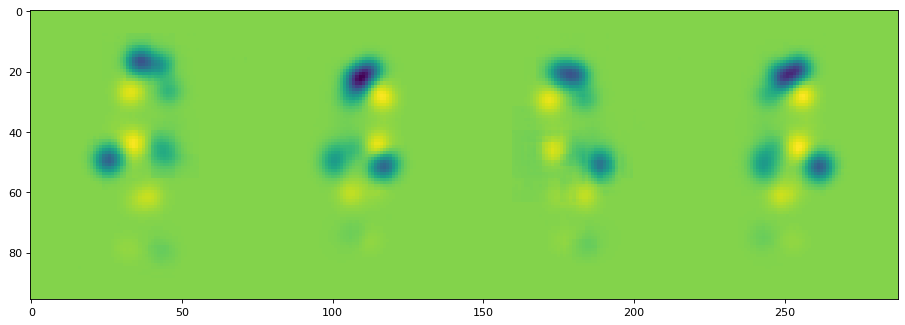

In [35]:
heatmap_output_0 = heatmap_output[0].detach().cpu().numpy()
heatmap_output_1 = heatmap_output[1].detach().cpu().numpy()
heatmap_output_2 = heatmap_output[2].detach().cpu().numpy()
heatmap_output_3 = heatmap_output[3].detach().cpu().numpy() # (25, 256, 256)


heatmap_output_cv2_0 = np.transpose(heatmap_output_0, (1,2,0))
heatmap_output_sum_0 = np.sum(heatmap_output_cv2_0, axis=2, keepdims=False)
heatmap_output_cv2_1 = np.transpose(heatmap_output_1, (1,2,0))
heatmap_output_sum_1 = np.sum(heatmap_output_cv2_1, axis=2, keepdims=False)
heatmap_output_cv2_2 = np.transpose(heatmap_output_2, (1,2,0))
heatmap_output_sum_2 = np.sum(heatmap_output_cv2_2, axis=2, keepdims=False)
heatmap_output_cv2_3 = np.transpose(heatmap_output_3, (1,2,0))
heatmap_output_sum_3 = np.sum(heatmap_output_cv2_3, axis=2, keepdims=False)

concated_output_tmp = cv2.hconcat([heatmap_output_sum_0, heatmap_output_sum_1,\
                        heatmap_output_sum_2, heatmap_output_sum_3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated_output_tmp)

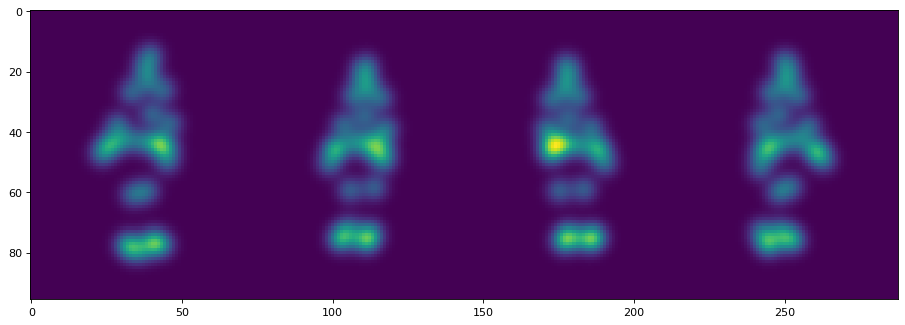

In [36]:
heatmap_gt_0 = heatmap_gt[0].detach().cpu().numpy()
heatmap_gt_1 = heatmap_gt[1].detach().cpu().numpy()
heatmap_gt_2 = heatmap_gt[2].detach().cpu().numpy()
heatmap_gt_3 = heatmap_gt[3].detach().cpu().numpy() # (25, 256, 256)


heatmap_gt_cv2_0 = np.transpose(heatmap_gt_0, (1,2,0))
heatmap_gt_sum_0 = np.sum(heatmap_gt_cv2_0, axis=2, keepdims=False)
heatmap_gt_cv2_1 = np.transpose(heatmap_gt_1, (1,2,0))
heatmap_gt_sum_1 = np.sum(heatmap_gt_cv2_1, axis=2, keepdims=False)
heatmap_gt_cv2_2 = np.transpose(heatmap_gt_2, (1,2,0))
heatmap_gt_sum_2 = np.sum(heatmap_gt_cv2_2, axis=2, keepdims=False)
heatmap_gt_cv2_3 = np.transpose(heatmap_gt_3, (1,2,0))
heatmap_gt_sum_3 = np.sum(heatmap_gt_cv2_3, axis=2, keepdims=False)

concated_tmp = cv2.hconcat([heatmap_gt_sum_0, heatmap_gt_sum_1,\
                        heatmap_gt_sum_2, heatmap_gt_sum_3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated_tmp)

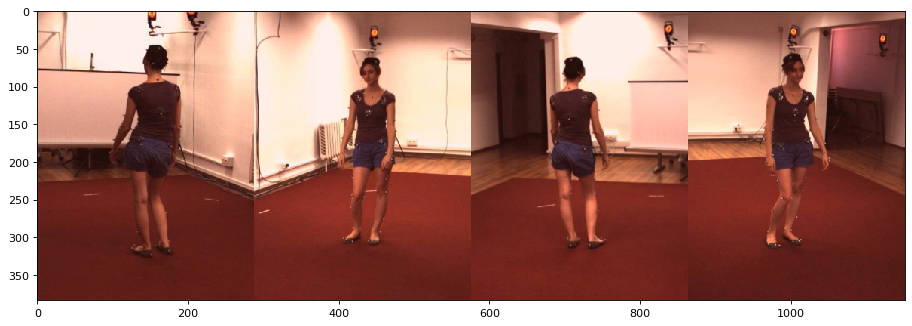

In [37]:
batch_image_cam0 = batch['images'][0, :, :, :, :][0,:,:,:]
batch_image_cam0 = cv2.normalize(batch_image_cam0, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

batch_image_cam1 = batch['images'][0, :, :, :, :][1,:,:,:]
batch_image_cam1 = cv2.normalize(batch_image_cam1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

batch_image_cam2 = batch['images'][0, :, :, :, :][2,:,:,:]
batch_image_cam2 = cv2.normalize(batch_image_cam2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

batch_image_cam3 = batch['images'][0, :, :, :, :][3,:,:,:]
batch_image_cam3 = cv2.normalize(batch_image_cam3, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

concated = cv2.hconcat([batch_image_cam0, batch_image_cam1,\
                        batch_image_cam2, batch_image_cam3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated[:,:,::-1])

(4, 25, 96, 72)


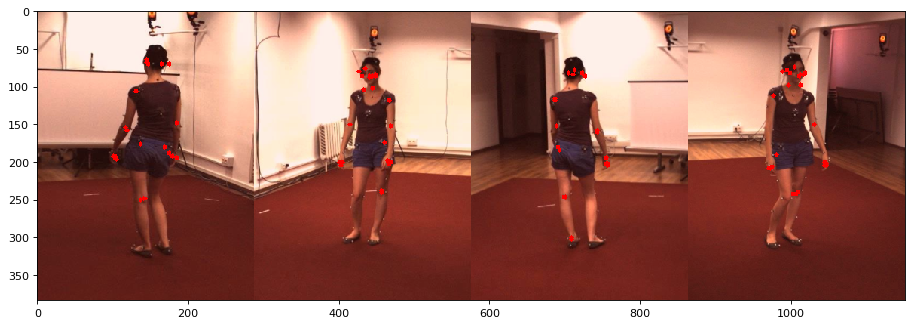

In [38]:
from mmpose.core.evaluation import keypoints_from_heatmaps
heatmap_output_stacked = np.stack([heatmap_output_0, heatmap_output_1, heatmap_output_2, heatmap_output_3], axis=0)
print(heatmap_output_stacked.shape)

# pixel std is 200.0
x = 0
y = 0
w = 288
h = 384

# input_size = cfg.data_cfg['image_size']
# aspect_ratio = input_size[0] / input_size[1]
# aspect_ratio = 288 / 384
center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

# if w > aspect_ratio * h:
#     h = w * 1.0 / aspect_ratio
# elif w < aspect_ratio * h:
#     w = h * aspect_ratio

scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
# scale = scale * 1.25

# scale = np.array([max(w / 200.0, h / 200.0), max(w / 200.0, h / 200.0)], dtype=np.float32)
batch_scale = np.zeros((heatmap_output_stacked.shape[0], 2))
batch_center = np.zeros((heatmap_output_stacked.shape[0], 2))
batch_scale[:] = scale
batch_center[:] = center

reds, maxvals = keypoints_from_heatmaps(heatmap_output_stacked, center=batch_center, scale=batch_scale)

plt_0 = copy.deepcopy(batch_image_cam0)
plt_1 = copy.deepcopy(batch_image_cam1)
plt_2 = copy.deepcopy(batch_image_cam2)
plt_3 = copy.deepcopy(batch_image_cam3)

for j in range(reds.shape[1]):
    plt_0 = cv2.circle(plt_0, (int(reds[0,j,0]),int(reds[0,j,1])), 0, [0, 0, 255], 5)
    plt_1 = cv2.circle(plt_1, (int(reds[1,j,0]),int(reds[1,j,1])), 0, [0, 0, 255], 5)
    plt_2 = cv2.circle(plt_2, (int(reds[2,j,0]),int(reds[2,j,1])), 0, [0, 0, 255], 5)
    plt_3 = cv2.circle(plt_3, (int(reds[3,j,0]),int(reds[3,j,1])), 0, [0, 0, 255], 5)

concated = cv2.hconcat([plt_0, plt_1,\
                        plt_2, plt_3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated[:,:,::-1])

(4, 25, 96, 72)


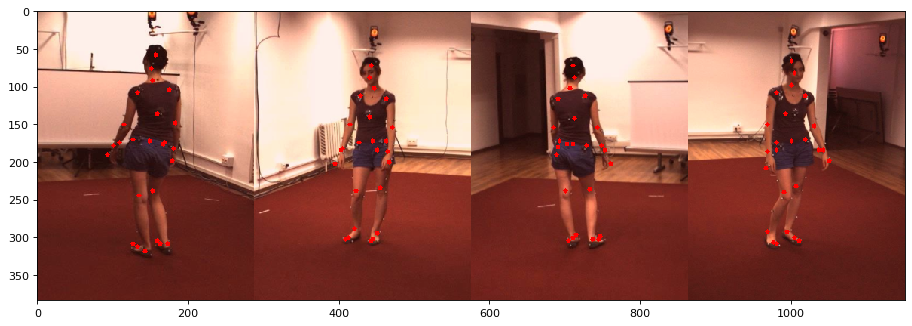

In [39]:
from mmpose.core.evaluation import keypoints_from_heatmaps
heatmap_gt_stacked = np.stack([heatmap_gt_0, heatmap_gt_1, heatmap_gt_2, heatmap_gt_3], axis=0)
print(heatmap_gt_stacked.shape)

# pixel std is 200.0
x = 0
y = 0
w = 288
h = 384

# input_size = cfg.data_cfg['image_size']
# aspect_ratio = input_size[0] / input_size[1]
# aspect_ratio = 288 / 384
center = np.array([x + w * 0.5, y + h * 0.5], dtype=np.float32)

# if w > aspect_ratio * h:
#     h = w * 1.0 / aspect_ratio
# elif w < aspect_ratio * h:
#     w = h * aspect_ratio

scale = np.array([w / 200.0, h / 200.0], dtype=np.float32)
# scale = scale * 1.25

# scale = np.array([max(w / 200.0, h / 200.0), max(w / 200.0, h / 200.0)], dtype=np.float32)
batch_scale = np.zeros((heatmap_gt_stacked.shape[0], 2))
batch_center = np.zeros((heatmap_gt_stacked.shape[0], 2))
batch_scale[:] = scale
batch_center[:] = center

reds, maxvals = keypoints_from_heatmaps(heatmap_gt_stacked, center=batch_center, scale=batch_scale)

plt_0 = copy.deepcopy(batch_image_cam0)
plt_1 = copy.deepcopy(batch_image_cam1)
plt_2 = copy.deepcopy(batch_image_cam2)
plt_3 = copy.deepcopy(batch_image_cam3)

for j in range(reds.shape[1]):
    plt_0 = cv2.circle(plt_0, (int(reds[0,j,0]),int(reds[0,j,1])), 0, [0, 0, 255], 5)
    plt_1 = cv2.circle(plt_1, (int(reds[1,j,0]),int(reds[1,j,1])), 0, [0, 0, 255], 5)
    plt_2 = cv2.circle(plt_2, (int(reds[2,j,0]),int(reds[2,j,1])), 0, [0, 0, 255], 5)
    plt_3 = cv2.circle(plt_3, (int(reds[3,j,0]),int(reds[3,j,1])), 0, [0, 0, 255], 5)

concated = cv2.hconcat([plt_0, plt_1,\
                        plt_2, plt_3])

figure(num=None, figsize=(14, 11), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(concated[:,:,::-1])